In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from utils import convert_less_than, plot_distribution

In [164]:
COLUMNS = ["Carbon concentration / (weight%)", 
           "Silicon concentration / (weight%)", 
           "Manganese concentration / (weight%)", 
           "Sulphur concentration / (weight%)", 
           "Phosphorus concentration / (weight%)", 
           "Nickel concentration / (weight%)", 
           "Chromium concentration / (weight%)", 
           "Molybdenum concentration / (weight%)", 
           "Vanadium concentration / (weight%)", 
           "Copper concentration / (weight%)", 
           "Cobalt concentration / (weight%)", 
           "Tungsten concentration / (weight%)", 
           "Oxygen concentration / parts per million by weight", 
           "Titanium concentration / parts per million by weight", 
           "Nitrogen concentration / parts per million by weight", 
           "Aluminium concentration / parts per million by weight", 
           "Boron concentration / parts per million by weight", 
           "Niobium concentration / parts per million by weight", 
           "Tin concentration / parts per million by weight", 
           "Arsenic concentration / parts per million by weight", 
           "Antimony concentration / parts per million by weight", 
           "Current / A", 
           "Voltage / V", 
           "AC or DC", 
           "Electrode positive or negative", 
           "Heat input / kJmm-1", 
           "Interpass temperature / °C", 
           "Type of weld", 
           "Post weld heat treatment temperature / °C", 
           "Post weld heat treatment time / hours", 
           "Yield strength / MPa", 
           "Ultimate tensile strength / MPa", 
           "Elongation / %", 
           "Reduction of Area / %", 
           "Charpy temperature / °C", 
           "Charpy impact toughness / J", 
           "Hardness / kgmm-2", 
           "50% FATT", 
           "Primary ferrite in microstructure / %", 
           "Ferrite with second phase / %", 
           "Acicular ferrite / %", 
           "Martensite / %", 
           "Ferrite with carbide aggreagate / %",
            "Weld ID"
            ]
CATEGORICAL_COL = [
    "AC or DC", 
    "Electrode positive or negative", 
    "Type of weld", 
    "Weld ID"
]
MECHANICAL_PROPERTIES = [
    "Yield strength / MPa",
    "Ultimate tensile strength / MPa",
    "Elongation / %",
    "Reduction of Area / %",
    "Charpy temperature / °C",
    "Charpy impact toughness / J",
    "Hardness / kgmm-2",
    "50% FATT",
    "Primary ferrite in microstructure / %",
    "Ferrite with second phase / %",
    "Acicular ferrite / %",
    "Martensite / %",
    "Ferrite with carbide aggreagate / %"
]
NUMERICAL_COL = list(set(COLUMNS) - set(CATEGORICAL_COL))

In [165]:
def create_database(file_path):

    db = pd.read_csv(file_path, delimiter = "\s+", names=COLUMNS, na_values='N').drop('Weld ID', axis=1)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].apply(convert_less_than)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].apply(pd.to_numeric, errors='coerce')

    db.to_csv("table.csv", index=False)
    return db

In [166]:
file_path="welddb/welddb.data"
db = create_database(file_path)

### - Handling outliers

KEEP IN MIND:

If you impute missing values first, the imputation might be influenced by outliers, leading to biased values. By removing or adjusting outliers first, you can achieve a more representative imputation.


Some algorithms (like linear regression) are sensitive to outliers, which can heavily influence the results. Handling outliers first might lead to a more stable model if the algorithm you choose is susceptible to them.

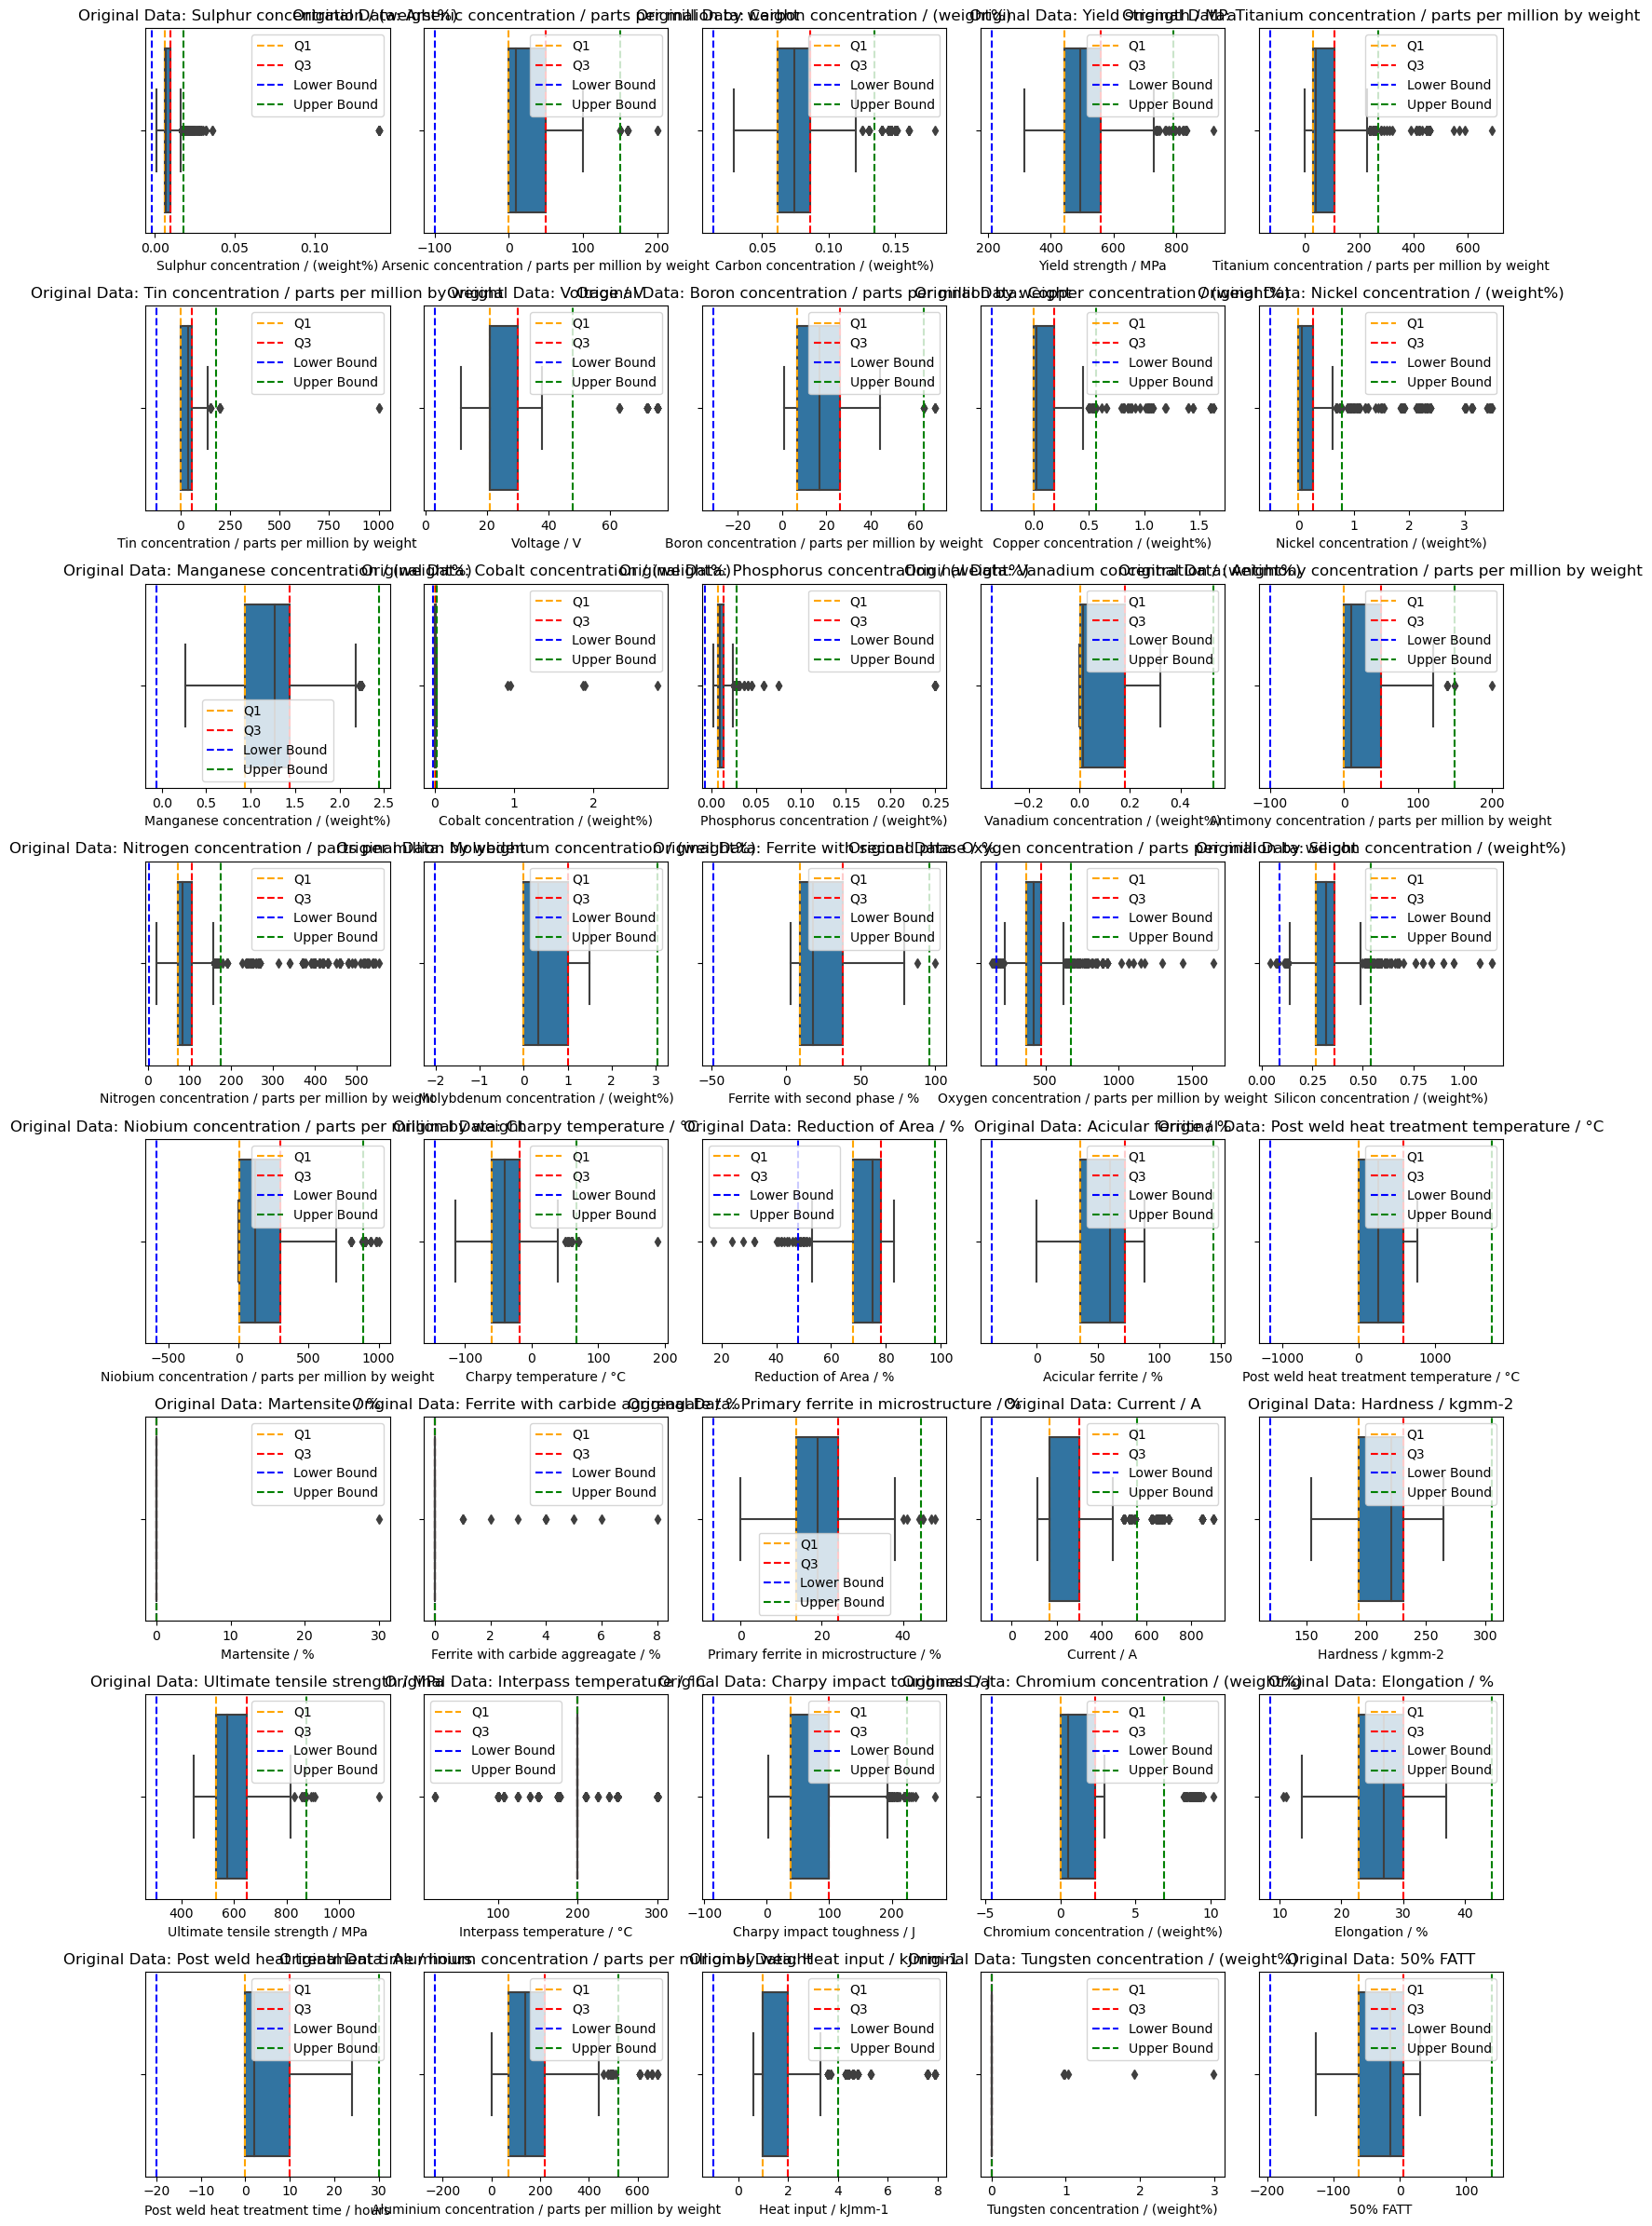

In [167]:
# Set up the figure for plotting
num_features = len(NUMERICAL_COL)
n_cols = 5  
n_rows = (num_features + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = axes.flatten()

def plot_distribution_with_quartiles(original_data, feature, ax):
    # Calculate quartiles and IQR for original data
    Q1 = original_data[feature].quantile(0.25)
    Q3 = original_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Boxplot for original data
    sns.boxplot(x=original_data[feature], ax=ax)
    ax.axvline(Q1, color='orange', linestyle='--', label='Q1')
    ax.axvline(Q3, color='red', linestyle='--', label='Q3')
    ax.axvline(lower_bound, color='blue', linestyle='--', label='Lower Bound')
    ax.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    ax.set_title(f'Original Data: {feature}')
    ax.legend()

# Plot distributions for each numerical feature
for i, col in enumerate(NUMERICAL_COL):
    plot_distribution_with_quartiles(db, col, axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [168]:
# Strategy to deal with outliers ???

### - Handling categorical features
- Handling **'Type of weld'** feature

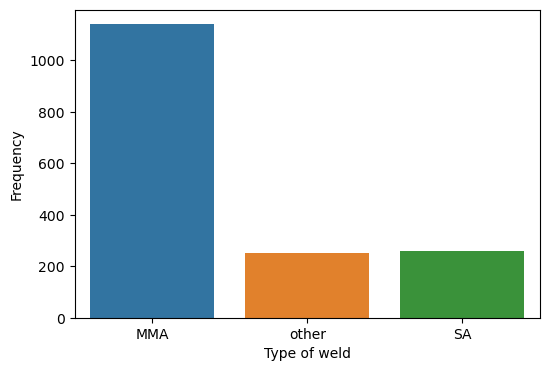

In [169]:
types_of_weld = ['MMA', 'SA', 'other']

db.loc[:, 'Type of weld'] = db['Type of weld'].apply(lambda x: x if x in types_of_weld else 'other')
plot_distribution(db['Type of weld'])

db = pd.get_dummies(db, columns=['Type of weld'], prefix='weld', dtype=int,).drop(columns=['weld_other'])

CATEGORICAL_COL.extend(['weld_MMA', 'weld_SA'])

- Handling **'AC or DC'** feature

In [170]:
cpt = 0

for i, row in db.iterrows():
    if pd.isna(row["AC or DC"]):
        
        if row['Electrode positive or negative'] == 0:
            cpt += 1
            db.loc[i, "AC or DC"] = "AC"  
        else:
            cpt += 1
            db.loc[i, "AC or DC"] = "DC"

print(f"Total imputed: {cpt}")

Total imputed: 215


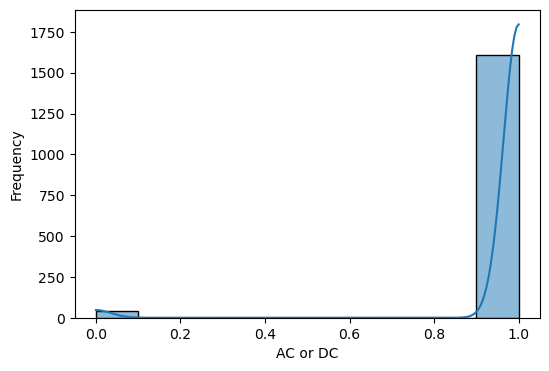

In [171]:
mapping_dict = {'AC': 0, 'DC': 1}
db['AC or DC'] = db['AC or DC'].map(mapping_dict)

plot_distribution(db['AC or DC'])

- Handling **'Electrode positive or negative'** feature

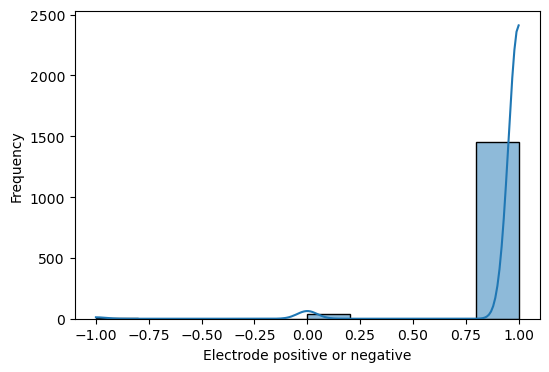

In [172]:
mapping_dict = {'+': 1, '0': 0, '-': -1}
db['Electrode positive or negative'] = db['Electrode positive or negative'].map(mapping_dict)
plot_distribution(db['Electrode positive or negative'])

### - Selecting relavant features based on Correlation and Completeness
#### TARGET = Yield strength / MPa

In [173]:
def get_corr(table:pd.DataFrame, threshold):
    # Initialize the result dictionary
    col_info = {
        'below_threshold': [],  # Columns with too many missing values
        'above_threshold': [],  # Columns passing the threshold
        'columns': {}           # Store correlation and missing percentage
    }
    
    for col in table.columns:
        column = table[col]
        missing_ratio = column.isnull().mean()
        
        col_info['columns'][col] = {'missing_ratio': missing_ratio}
        if missing_ratio > 1 - threshold:
            col_info['below_threshold'].append(col)
        else:
            col_info['above_threshold'].append(col)
        
        valid_rows = table[[col, 'Yield strength / MPa']].dropna()
        
        if not valid_rows.empty and col not in CATEGORICAL_COL:
            correlation = valid_rows.corr()
            col_info['columns'][col]['correlation_with_output'] = correlation.values[0,1]
        else:
            col_info['columns'][col]['correlation_with_output'] = np.nan  # No valid data to correlate

    return col_info

In [174]:
threshold = 0.3
col_info = get_corr(db, threshold)
# col_info

In [175]:
points = np.array([(0, 0.45), (0.6, 0.05)])
x_points = points[:, 0]
y_points = points[:, 1]
coefficients = np.polyfit(x_points, y_points, 2)
feature_decision = np.vectorize(lambda completeness: max(0.05, np.polyval(coefficients, completeness)))


def plot_completeness_vs_corr(col_info, feature_decision=feature_decision):
    # Initialize lists to store x (completeness) and y (correlation) values
    x_completeness = []
    y_correlation = []
    column_names = []

    if feature_decision is None:
        features = col_info
    else:
        features=[]

    # Loop through the columns in col_info
    for col, info in col_info['columns'].items():
        if 'correlation_with_output' in info:  # Only consider columns with calculated correlation
            if col=='output':
                continue

            completeness = 1 - info['missing_ratio'] 
            correlation = abs(info['correlation_with_output'])
            
            x_completeness.append(completeness)
            y_correlation.append(correlation)
            column_names.append(col)
            if feature_decision is not None and feature_decision(completeness) >= correlation:
                features.append(col)
    
    # Plotting
    plt.figure(figsize=(20, 20))
    plt.scatter(x_completeness, y_correlation, color='b', marker='o')
    plt.ylim(0, 0.5)
    
    # Label each point with the column name
    for i, txt in enumerate(column_names):
        plt.annotate(txt, (x_completeness[i], y_correlation[i]), fontsize=9, ha='right')

    if feature_decision is not None:
        comp = np.linspace(min(x_completeness), max(x_completeness), 100)
        corr = feature_decision(comp)
        plt.plot(comp, corr, '-r')

    # Labels and title (in French)
    plt.xlabel("Complétude de la colonne (%)", fontsize=12)
    plt.ylabel("Corrélation avec 'output' en valeur absolue", fontsize=12)
    plt.title("Complétude vs Corrélation avec 'output'= Yield strength / MPa", fontsize=14)

    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

    return features

c:\Users\natha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


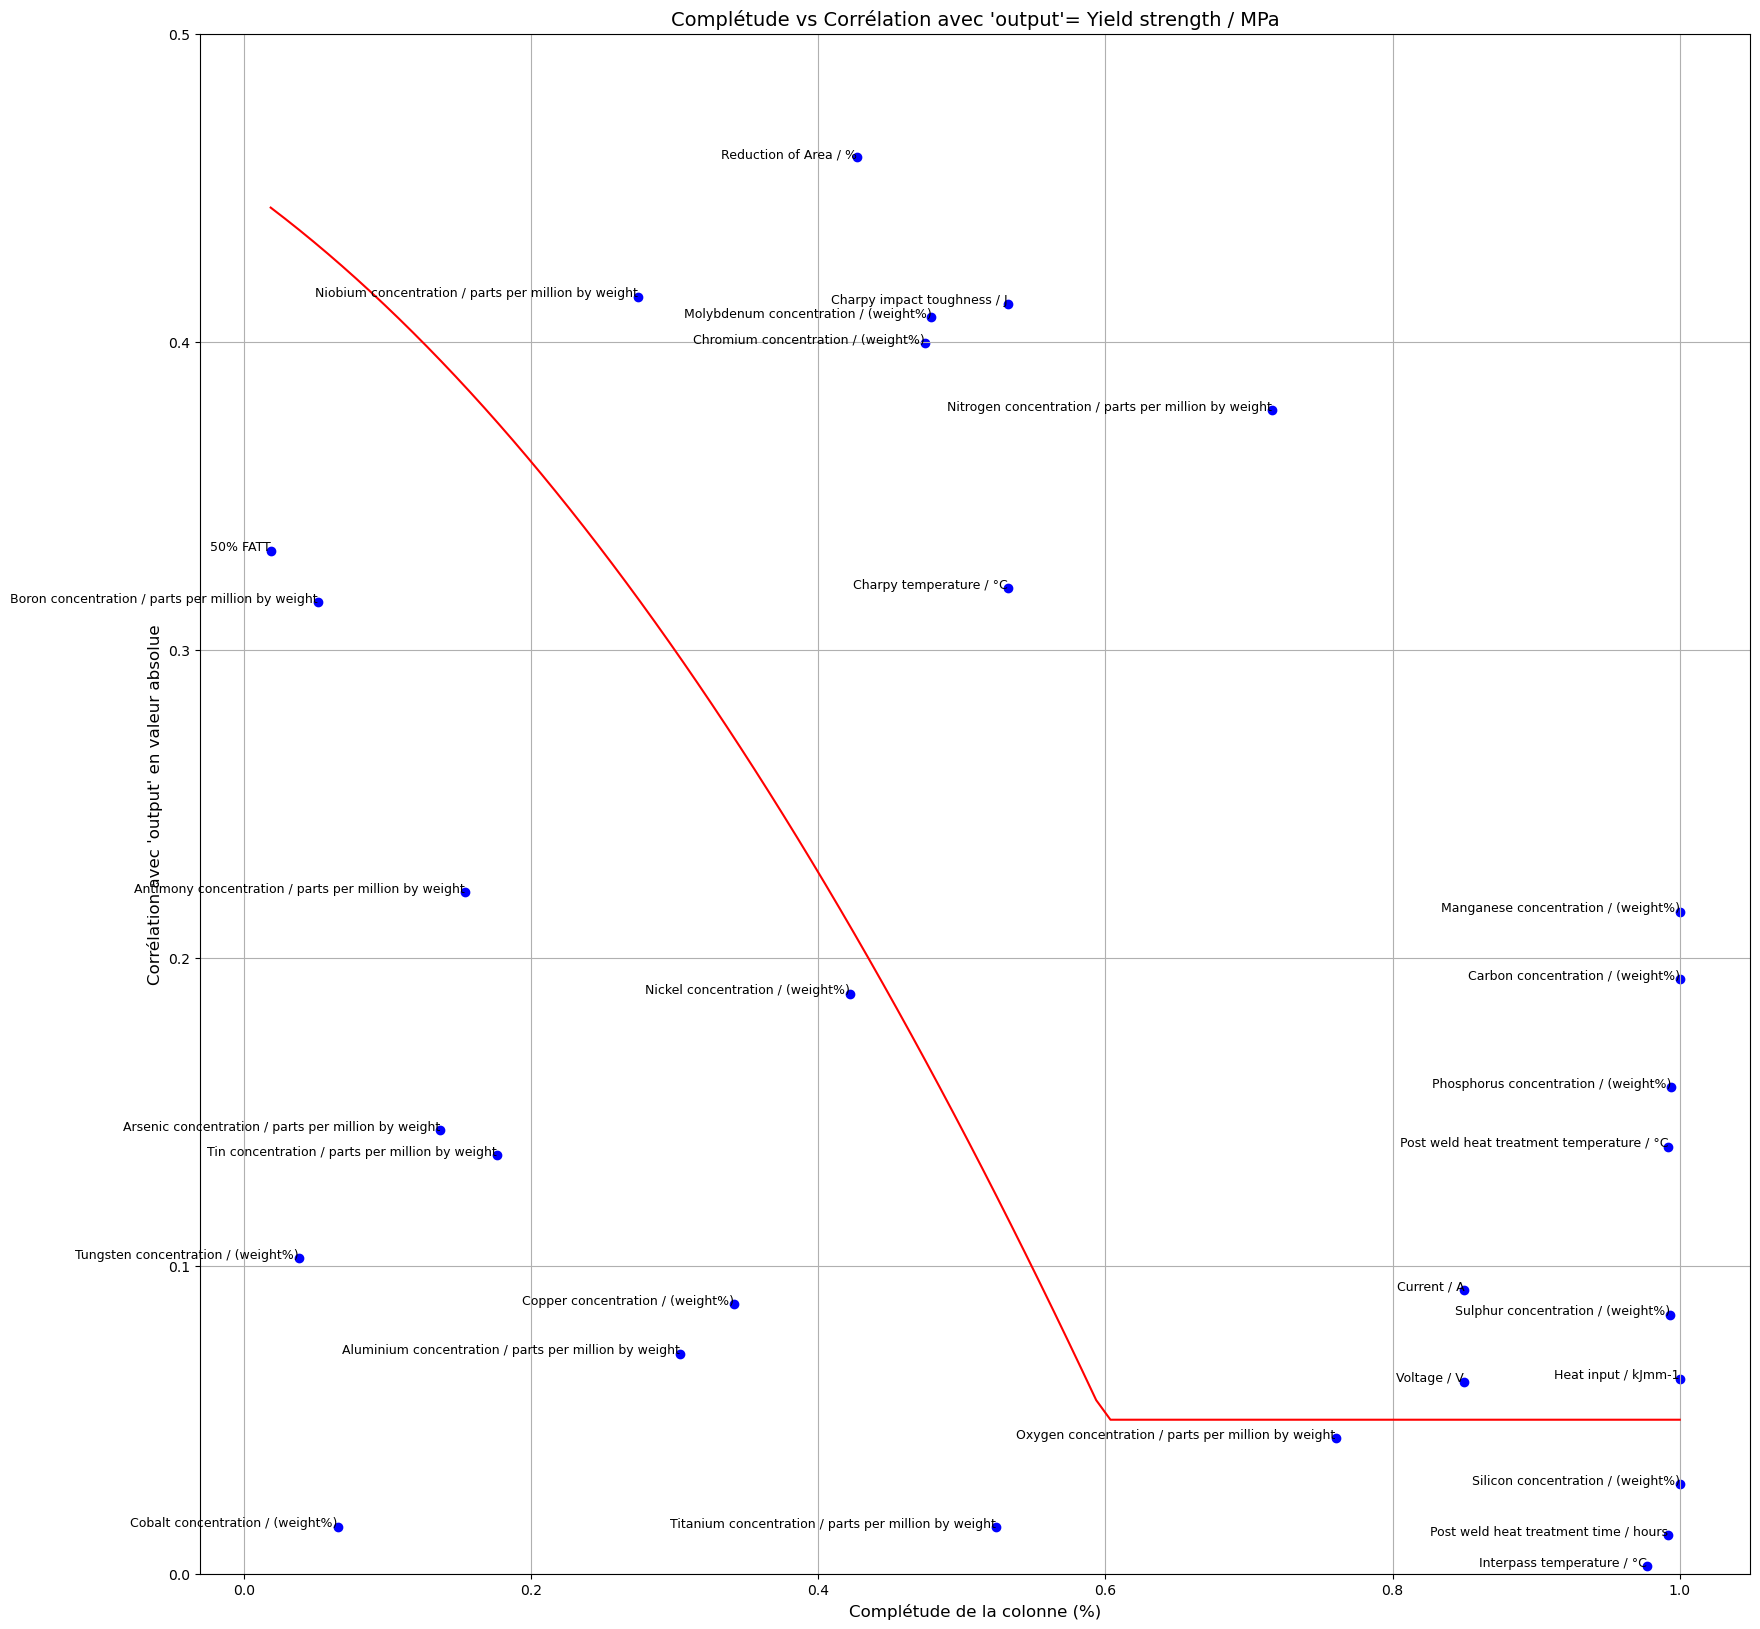

In [176]:
irrelevant_features = plot_completeness_vs_corr(col_info)

In [177]:
relevant_features = list(set(db.columns) - set(irrelevant_features) - set(MECHANICAL_PROPERTIES) | set(["Yield strength / MPa"]))
df = db[relevant_features]

In [178]:
df.isna().mean()

Sulphur concentration / (weight%)                       0.006659
Molybdenum concentration / (weight%)                    0.521186
Carbon concentration / (weight%)                        0.000000
Yield strength / MPa                                    0.527845
Niobium concentration / parts per million by weight     0.725787
Voltage / V                                             0.150121
Post weld heat treatment temperature / °C               0.007869
Current / A                                             0.150121
weld_SA                                                 0.000000
Manganese concentration / (weight%)                     0.000000
Electrode positive or negative                          0.094431
Phosphorus concentration / (weight%)                    0.006053
Chromium concentration / (weight%)                      0.525424
Vanadium concentration / (weight%)                      0.624697
Heat input / kJmm-1                                     0.000000
AC or DC                 

### - Handling missing values
- Numerical values

In [179]:
df1 = df.copy()

num_cols_to_impute = list(set(df1.columns) - set(CATEGORICAL_COL) - set(["Yield strength / MPa"]))
num_cols_to_impute

['Sulphur concentration / (weight%)',
 'Molybdenum concentration / (weight%)',
 'Carbon concentration / (weight%)',
 'Manganese concentration / (weight%)',
 'Phosphorus concentration / (weight%)',
 'Niobium concentration / parts per million by weight',
 'Voltage / V',
 'Chromium concentration / (weight%)',
 'Post weld heat treatment temperature / °C',
 'Vanadium concentration / (weight%)',
 'Heat input / kJmm-1',
 'Current / A',
 'Nitrogen concentration / parts per million by weight']

In [180]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer(random_state=42, sample_posterior=True)

df1[num_cols_to_impute] = iterative_imputer.fit_transform(df1[num_cols_to_impute])

- Categorical values

In [181]:
non_missing_values = df['Electrode positive or negative'].dropna()

def random_imputation(series):

    missing = series.isnull()
    imputed_values = non_missing_values.sample(n=missing.sum(), replace=True, random_state=42).values
    series.loc[missing] = imputed_values

    return series

df1['Electrode positive or negative'] = random_imputation(df1['Electrode positive or negative'])

C:\Users\natha\AppData\Local\Temp\ipykernel_11100\2725299324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[missing] = imputed_values


In [182]:
df1.to_csv("table_with_imputations.csv", index=False)

### Extracting dataset where TARGET != None

In [183]:
db["Yield strength / MPa"].isna().mean()

0.5278450363196125

We extract rows with "Yield strength / MPa" not None to create our dataset.

In [184]:
df = db.dropna(subset=['Yield strength / MPa'])
df.shape

(780, 44)

### PCA Analysis of the completion to find extra outliers

#### Relevant number of features

In [220]:
pca_features = list(set(relevant_features) - set(["Yield strength / MPa"]+ CATEGORICAL_COL))
df_pca = (df1[pca_features] - df1[pca_features].mean())/df1[pca_features].std()

0       1
1       1
2       1
3       1
4       1
       ..
1647    2
1648    2
1649    2
1650    2
1651    2
Length: 1652, dtype: int32

In [186]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(pca_features))
df_principal_components = pca.fit_transform(df_pca)

nb_relevant_features = 1
cumsum = np.cumsum(pca.explained_variance_ratio_)
while cumsum[nb_relevant_features-1] < 0.8:
    nb_relevant_features += 1

nb_relevant_features

5

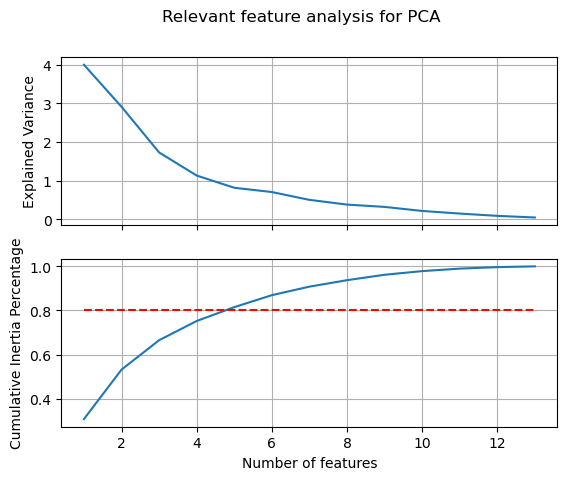

In [187]:
fig, axs = plt.subplots(2,1, sharex=True)

axs[0].plot(list(range(1, len(pca.explained_variance_)+1)), pca.explained_variance_)
axs[0].set_ylabel("Explained Variance")
axs[0].grid()

axs[1].plot(list(range(1, len(pca.explained_variance_)+1)), np.cumsum(pca.explained_variance_ratio_))
axs[1].set_xlabel("Number of features")
axs[1].set_ylabel("Cumulative Inertia Percentage")
axs[1].plot(list(range(1, len(pca.explained_variance_)+1)), [0.8]*len(pca_features), color = "r", linestyle='dashed')
axs[1].grid()

fig.suptitle("Relevant feature analysis for PCA")

plt.show()

### Analysis of PCA Results

In [251]:
df_principal_components = df_principal_components[:,:nb_relevant_features]

In [189]:
def plot_precise_distribution(column):
    
    plt.figure(figsize=(6, 4))

    if pd.api.types.is_numeric_dtype(column):
        sns.histplot(column, kde=True, bins=100)
    else:
        sns.countplot(x=column)
    
    plt.ylabel('Frequency')
    plt.show()

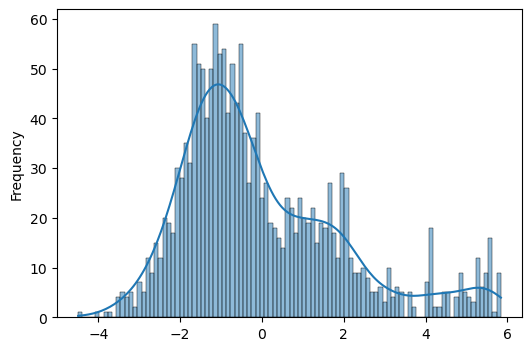

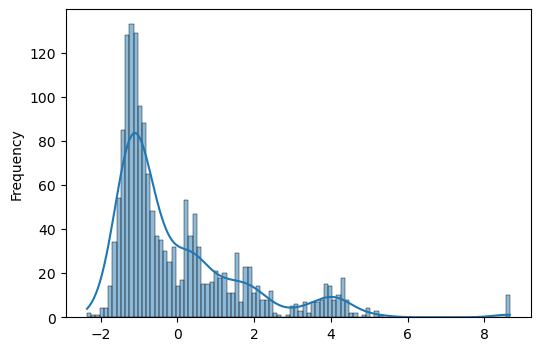

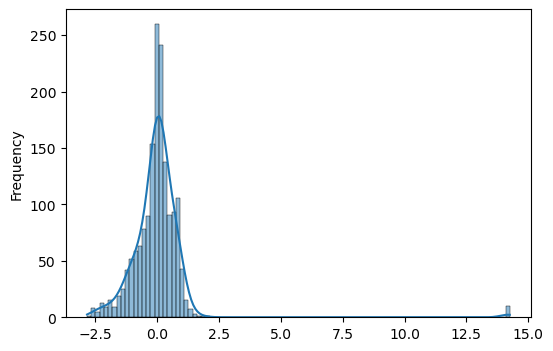

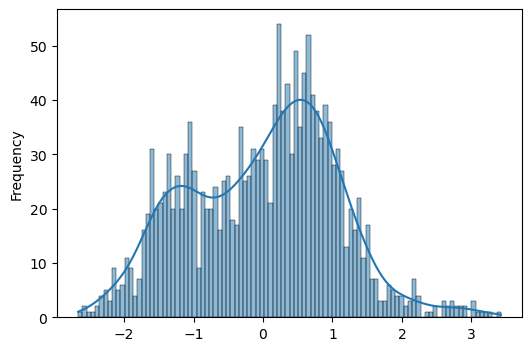

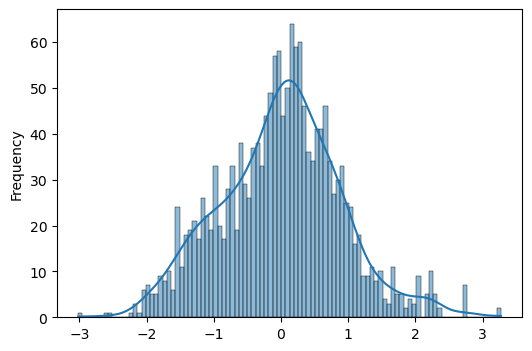

In [190]:
for feature in range(nb_relevant_features):
    plot_precise_distribution(df_principal_components[:,feature])

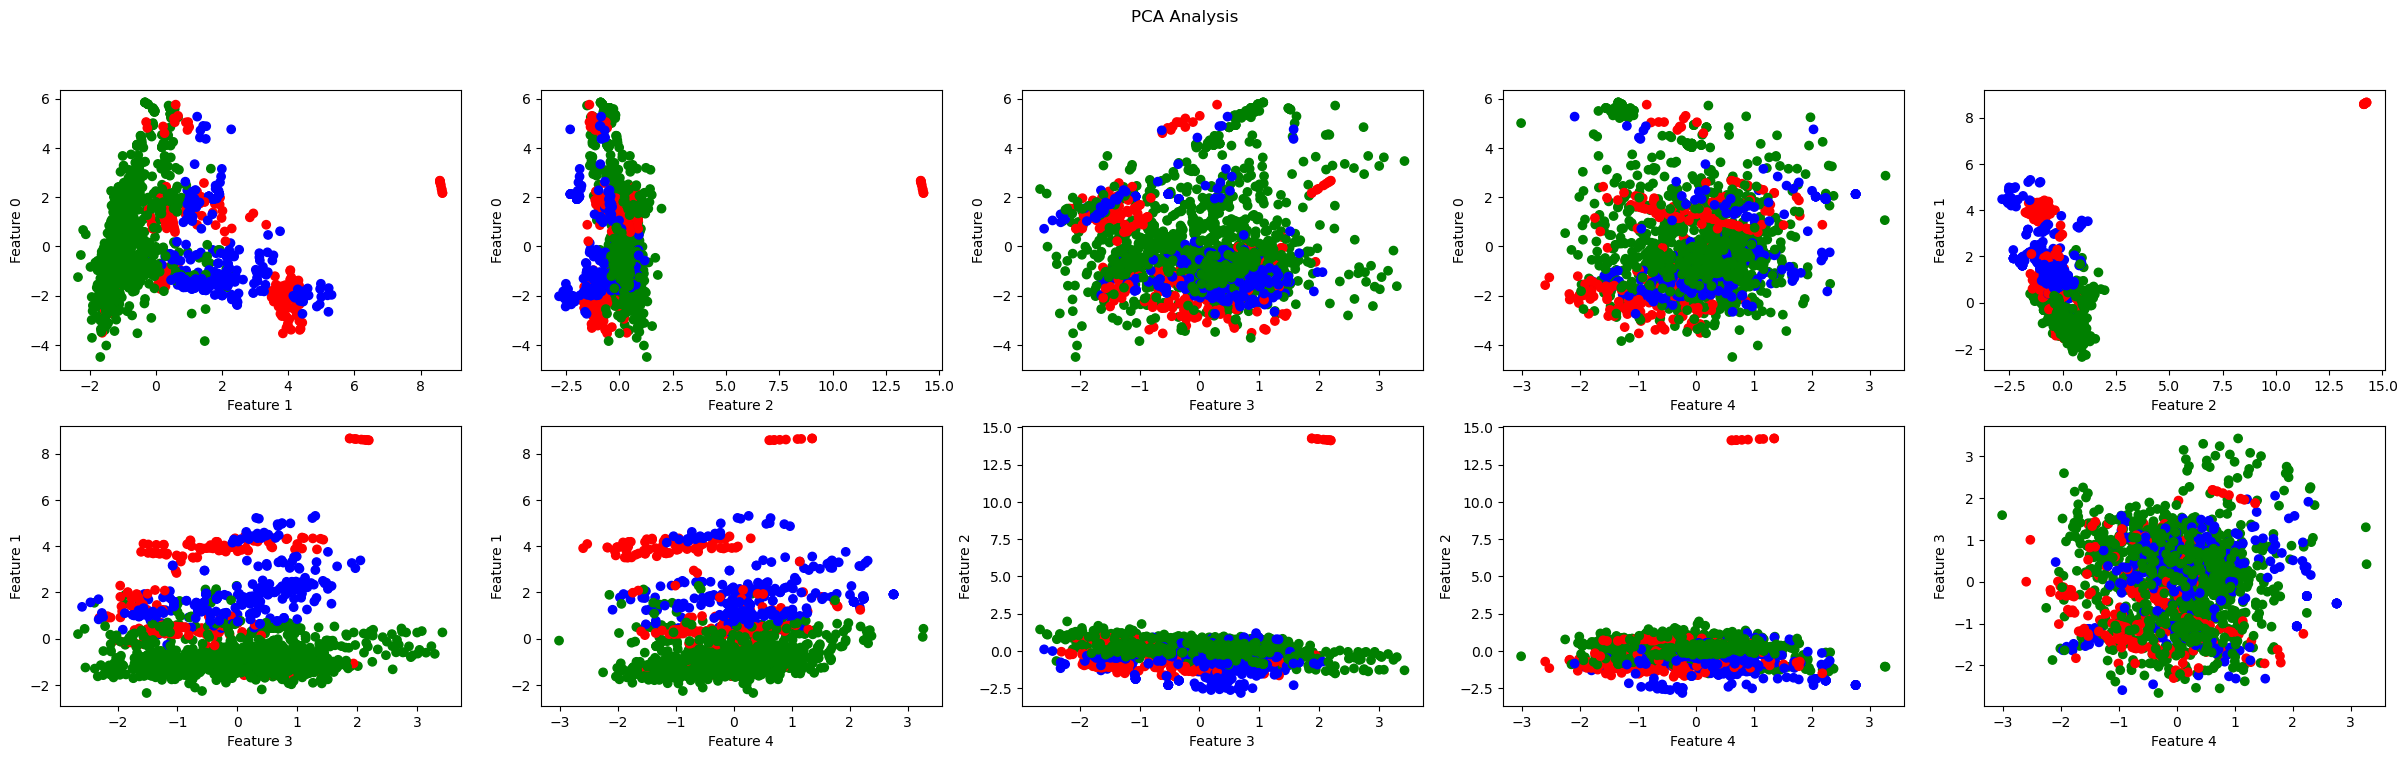

In [235]:
n_cols = nb_relevant_features*(nb_relevant_features-1)//4
n_rows = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))

counter = 0
for featurey in range(nb_relevant_features):
    for featurex in range(featurey+1,nb_relevant_features):
        axs[counter//n_cols,counter%n_cols].scatter(df_principal_components[:,featurex], df_principal_components[:,featurey], color = (df1['weld_MMA'] + 2*df1["weld_SA"]).apply(lambda x:"r" if x ==0 else "g" if x ==1 else "b"))
        axs[counter//n_cols,counter%n_cols].set_xlabel(f"Feature {featurex}")
        axs[counter//n_cols,counter%n_cols].set_ylabel(f"Feature {featurey}")
        counter += 1
fig.suptitle("PCA Analysis")
plt.show()

### Representation of welding features in the PCA components

In [268]:
vectors = pca.transform(np.eye(len(pca_features)))[:,:nb_relevant_features]
dict_representation = {pca_features[i] : np.linalg.norm(vectors[i]) for i in range(len(vectors))}
dict_representation

c:\Users\natha\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


{'Sulphur concentration / (weight%)': 0.6874311923051498,
 'Molybdenum concentration / (weight%)': 0.5248816272594009,
 'Carbon concentration / (weight%)': 0.7973752254498444,
 'Manganese concentration / (weight%)': 0.732663782160825,
 'Phosphorus concentration / (weight%)': 0.7016670219043019,
 'Niobium concentration / parts per million by weight': 0.6376369373039686,
 'Voltage / V': 0.5737589629082912,
 'Chromium concentration / (weight%)': 0.5125840804499239,
 'Post weld heat treatment temperature / °C': 0.5317850928031699,
 'Vanadium concentration / (weight%)': 0.5573873685165305,
 'Heat input / kJmm-1': 0.5863065262088171,
 'Current / A': 0.5829287902010715,
 'Nitrogen concentration / parts per million by weight': 0.5580658780462091}

In [272]:
features = pca_features[:]
features.sort(key = lambda x:-dict_representation[x])       #Greatest norm at the beginning
features

['Carbon concentration / (weight%)',
 'Manganese concentration / (weight%)',
 'Phosphorus concentration / (weight%)',
 'Sulphur concentration / (weight%)',
 'Niobium concentration / parts per million by weight',
 'Heat input / kJmm-1',
 'Current / A',
 'Voltage / V',
 'Nitrogen concentration / parts per million by weight',
 'Vanadium concentration / (weight%)',
 'Post weld heat treatment temperature / °C',
 'Molybdenum concentration / (weight%)',
 'Chromium concentration / (weight%)']

In [258]:
from scipy.spatial.distance import cdist

cosine_corr = 1- cdist(vectors, vectors, "cosine")
threshold = 0.8
correlated = []

for i in range(len(cosine_corr)):
    for j in range(i):
        if cosine_corr[i,j] >= threshold:
            correlated.append([pca_features[j],pca_features[i]])

correlated.sort()
correlated

[['Chromium concentration / (weight%)',
  'Nitrogen concentration / parts per million by weight'],
 ['Heat input / kJmm-1', 'Current / A'],
 ['Molybdenum concentration / (weight%)',
  'Post weld heat treatment temperature / °C'],
 ['Niobium concentration / parts per million by weight',
  'Chromium concentration / (weight%)'],
 ['Niobium concentration / parts per million by weight',
  'Nitrogen concentration / parts per million by weight'],
 ['Sulphur concentration / (weight%)', 'Phosphorus concentration / (weight%)'],
 ['Voltage / V', 'Current / A'],
 ['Voltage / V', 'Heat input / kJmm-1']]